This notebook contains two functions. 

The first function inputs the page image path, page xml path and a mask text. It outputs a binary page_mask where the mask texts are white.

The second function inputs the page image path, page xml path and a mask text. It outputs a binary line_masks and line images which contain the mask text.

In [1]:
import os
import xml.etree.ElementTree as ET
import cv2
from IPython.display import display, Image
import PIL.Image
from io import BytesIO
import numpy as np

In [2]:
def show_image(img, fmt='png'):
    a = np.uint8(img)
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))
    
def xml_to_coordinates(t):
    result = []
    for p in t.split(' '):
        values = p.split(',')
        assert len(values) == 2
        x, y = int(float(values[0])), int(float(values[1]))
        result.append((x,y))
    result=np.array(result)
    return result

def page_mask_from_page_path_and_mask_text(page_image_path, page_xml_path, mask_text):
    page_image = cv2.imread(page_image_path,0)
    page_height, page_width = page_image.shape
    page_mask = np.zeros((page_height, page_width), np.uint8)

    tree = ET.parse(page_xml_path)
    root = tree.getroot()
    words = root.findall('{http://schema.primaresearch.org/PAGE/gts/pagecontent/2019-07-15}Page/'+
                         '{http://schema.primaresearch.org/PAGE/gts/pagecontent/2019-07-15}TextRegion/'+
                         '{http://schema.primaresearch.org/PAGE/gts/pagecontent/2019-07-15}TextLine/'+
                         '{http://schema.primaresearch.org/PAGE/gts/pagecontent/2019-07-15}Word')
    for word in words:
        unicode = word.find('{http://schema.primaresearch.org/PAGE/gts/pagecontent/2019-07-15}TextEquiv/'+
                            '{http://schema.primaresearch.org/PAGE/gts/pagecontent/2019-07-15}Unicode')
        word_text = unicode.text
        if word_text == mask_text:
            coords = word.find('{http://schema.primaresearch.org/PAGE/gts/pagecontent/2019-07-15}Coords')
            points = coords.attrib['points']
            cnt = xml_to_coordinates(points)
            (x,y,w,h) = cv2.boundingRect(cnt)
            cv2.rectangle(page_mask, (x,y), (x+w,y+h), (255,255,255), -1)
    page_mask = cv2.bitwise_and(page_image, page_mask)
    show_image(page_mask)
    return page_mask

def line_images_and_line_masks_from_page_path_and_mask_text(page_image_path, page_xml_path, mask_text):
    line_images = []
    line_masks = []
    page_image = cv2.imread(page_image_path,0)
    page_height, page_width = page_image.shape
    page_mask = page_mask_from_page_path_and_mask_text(page_image_path, page_xml_path, mask_text)

    tree = ET.parse(page_xml_path)
    root = tree.getroot()    
    lines = root.findall('{http://schema.primaresearch.org/PAGE/gts/pagecontent/2019-07-15}Page/'+
                         '{http://schema.primaresearch.org/PAGE/gts/pagecontent/2019-07-15}TextRegion/'+
                         '{http://schema.primaresearch.org/PAGE/gts/pagecontent/2019-07-15}TextLine')
    for line in lines:
        unicode = line.find('{http://schema.primaresearch.org/PAGE/gts/pagecontent/2019-07-15}TextEquiv/'+
                            '{http://schema.primaresearch.org/PAGE/gts/pagecontent/2019-07-15}Unicode')
        line_text = unicode.text
        if mask_text in line_text:
            coords = line.find('{http://schema.primaresearch.org/PAGE/gts/pagecontent/2019-07-15}Coords')
            points = coords.attrib['points']
            cnt = xml_to_coordinates(points)
            (x,y,w,h) = cv2.boundingRect(cnt)
            line_image = page_image[y:y+h, x:x+w]
            line_mask = page_mask[y:y+h, x:x+w]
            line_images.append(line_image)
            line_masks.append(line_mask)
            show_image(line_image)
            show_image(line_mask)

                                
    return line_images, line_masks

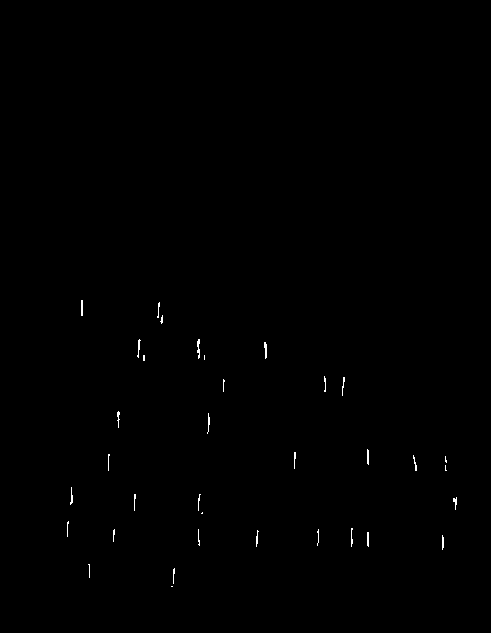

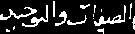

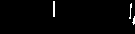

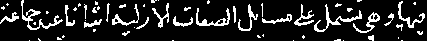

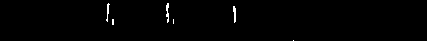

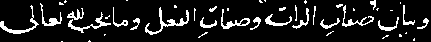

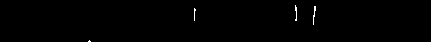

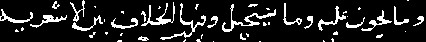

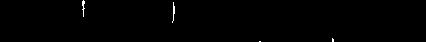

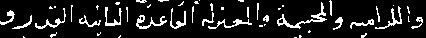

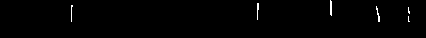

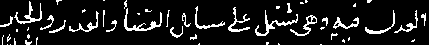

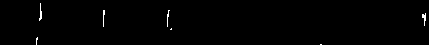

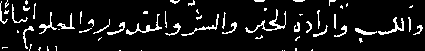

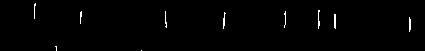

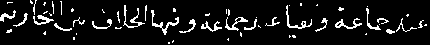

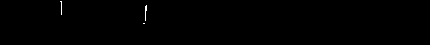

In [3]:
page_image_path = 'book1_binary_images/004-1.png'
page_xml_path = 'book1_words_lines_page_xmls/004-1.xml'
mask_text = 'ا'
line_images, line_masks = line_images_and_line_masks_from_page_path_and_mask_text(page_image_path, page_xml_path, mask_text)